In [123]:
import numpy as np
import pylab as plt
import torch
import pandas as pd

import swyft
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

In [124]:
torch.manual_seed(0)
np.random.seed(0)

Generate Training Data for simple power law with noise

Take function: $$\Omega_\mathrm{GW}(f)=\Omega_\mathrm{ref}\Big(\frac{f}{f_\mathrm{ref}}\Big)^\alpha$$,
 where
$\alpha \sim \mathcal{U}(-3, 3)$
$\Omega ref \sim \mathcal{U}(1e-13, 1e-9)$

We will be interested in the posterior distribution of alpha given an observation of x

In [125]:
# Setting up Simulator parameters
f_ref = 25
T_obs = 365 * 24 * 3600
f = np.arange(5.00,1024,1/4)

# Random sampling from prior
N = 10_000  # Number of samples
alpha = np.random.uniform(-3, 3, N) # Uniform prior over [-3, -3]
omega_ref = np.random.uniform(10**-13,10**-9, N)

# Combing Parameters
param = np.column_stack((alpha,omega_ref))

In [126]:
param.shape

(10000, 2)

Text(0.5, 1.0, 'Example sample - Marginal vs. Joined')

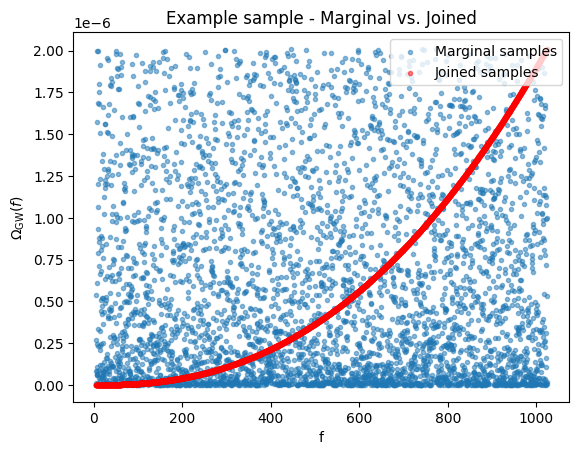

In [147]:
# Example generator using a random sample pair
sample_number = 209
omega_ex = param[sample_number,1]*(f/f_ref)**param[sample_number,0]

plt.scatter(f,np.random.permutation(omega_ex),alpha = 0.5, marker='.', label = "Marginal samples")
plt.scatter(f,omega_ex,alpha = 0.5, marker='.', color='r', label = "Joined samples")
plt.legend(loc = 1)
plt.xlabel('f')
plt.ylabel(r'$\Omega_\mathrm{GW}(f)$')
plt.title("Example sample - Marginal vs. Joined")

In [148]:
f.size

4076

In [149]:
# Generating 10_000 omega samples from random alpha and omega_ref

omega = np.zeros((f.size,N)) # Initialize np array

for i in range(N):
    omega[:,i] = param[i,1]*(f/f_ref)**param[i,0]


Text(0.5, 1.0, 'Example Sample for Omega')

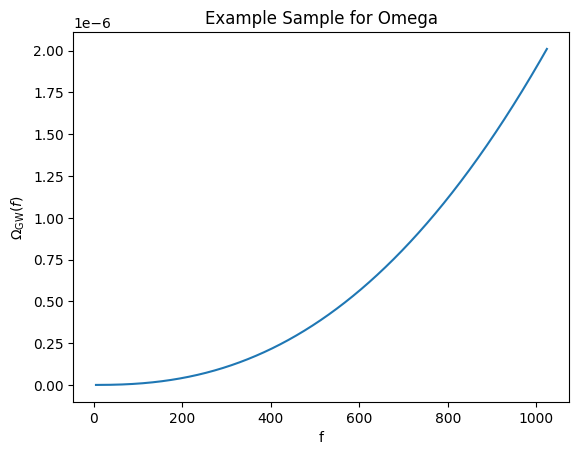

In [150]:
# Now we can plot f vs. omega
plt.plot(f,omega[:,sample_number])
plt.xlabel('f')
plt.ylabel(r'$\Omega_\mathrm{GW}(f)$')
plt.title("Example Sample for Omega")

In [156]:
# Storing Training Data in swyft object
samples = swyft.Samples(param = param, omega = np.transpose(omega))

In [157]:
print("Omega Shape: ",np.transpose(omega).shape)
print("Parameters Shape: ", param.shape)

Omega Shape:  (10000, 4076)
Parameters Shape:  (10000, 2)


In [158]:
#  Not sure how to do this part...

# Defining Network for Ratios
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 1, varnames = {'alpha', 'omega_ref'}, num_blocks = 4) #Posterior for z?

    def forward(self, A, B):
        return self.logratios(A['omega'], B['alpha'])

In [159]:
trainer = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [160]:
dm = swyft.SwyftDataModule(samples, batch_size=128)

In [ ]:
network = Network()
trainer.fit(network, dm)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 34.6 K
-----------------------------------------------------
34.6 K    Trainable params
0         Non-trainable params
34.6 K    Total params
0.276     Total estimated model params size (MB)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: 

Epoch 16: 100%|██████████| 79/79 [00:01<00:00, 39.60it/s, loss=0.000424, v_num=3, val_loss=6.03e-5]  
Reloading best model: /Users/abbystokes/Documents/GitHub/DSMMA-Research/lightning_logs/version_3/checkpoints/epoch=11-step=756.ckpt


In [161]:
x0 = 0
obs = swyft.Sample(x = np.array([x0]))

In [162]:
prior_samples = swyft.Samples(a = np.random.rand(5000, 1)*15-25)

In [163]:
predictions = trainer.infer(network, obs, prior_samples)

NameError: name 'network' is not defined

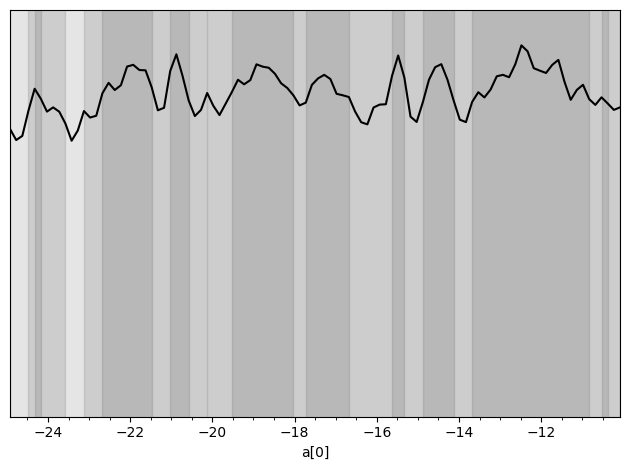

In [ ]:
swyft.plot_posterior(predictions, 'a[0]', smooth = 1)
#for offset in [-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6]:
 #   plt.axvline(x0+offset, color='g', ls = ':')
plt.axvline(x0)